## Computing phases in a ternary system
This method is based on the [paper](https://pubs.rsc.org/en/content/articlelanding/2019/sm/c8sm02045k#!divAbstract) which uses a convex envelope method but identifies the potential phases using a Laplacian based approach

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%config InlineBackend.figure_format = 'svg'
import mpltern
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns
import matplotlib.pyplot as plt

import pdb
import numpy as np

import sys
if '../' not in sys.path:
    sys.path.append('../')

from solvers.utils import makegrid3d, get_data

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [21]:
M,CHI,info=get_data(name='FHPaper',fhid=4)
grid = np.asarray(makegrid3d(num=40))

In [23]:
from solvers import helpers

gmix = lambda x: helpers.flory_huggins(x, M, CHI,beta=1e-4)
energy = []
for point in grid:
    energy.append(gmix(point))

In [24]:
# Plot a convex triangulation in the ternary space
from solvers.helpers import get_ternary_coords
from scipy.spatial import ConvexHull
coords = []
for point in grid:
    coords.append(get_ternary_coords(point))
points = np.concatenate((coords,np.asarray(energy).reshape(-1,1)),axis=1)
hull = ConvexHull(points)
coords = np.asarray(coords)

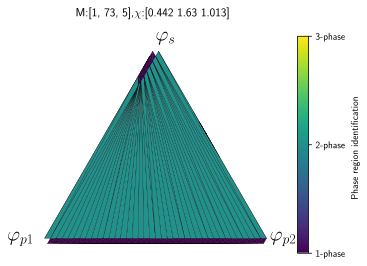

In [25]:
from scipy.spatial.distance import pdist, euclidean, squareform
from scipy.sparse import csr_matrix
import pandas as pd
from scipy.sparse.csgraph import connected_components

thresh = 5*euclidean(coords[0,:],coords[1,:])
num_comp_list = []

simplices = []
for simplex in hull.simplices:
    point_class = np.sum(np.isclose(grid[simplex],0.001),axis=1)
    point_class = np.unique(3 - point_class)
    if (point_class==1).any():
        pass
    else:
        simplices.append(simplex)

for triangle in simplices:
    tri_coords = coords[triangle,:]
    dist = squareform(pdist(tri_coords,'euclidean'))
    adjacency = dist<thresh
    adjacency =  adjacency.astype(int)  
    graph = csr_matrix(adjacency)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    num_comp_list.append(n_components)
    
fig, ax = plt.subplots()
ax.set_aspect('equal')
tpc = ax.tripcolor(coords[:,0], coords[:,1], simplices, facecolors=np.asarray(num_comp_list), edgecolors='k')
cbar = fig.colorbar(tpc, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(['1-phase', '2-phase', '3-phase'])
cbar.set_label('Phase region identification')

words = [r'$\varphi_{p1}$',r'$\varphi_{p2}$',r'$\varphi_{s}$']
xs = [-0.15,1,0.5]
ys = [0,0,np.sqrt(3)/2+0.01]
for x, y, s in zip(xs,ys,words):
    plt.text(x,y,s,fontsize=20)

ax.set_title(info['params'],pad=20)
plt.axis('off')
#plt.savefig('../figures/May13Wed/'+info['fname']+'.png',dpi=500,bbox_inches='tight')
plt.show()

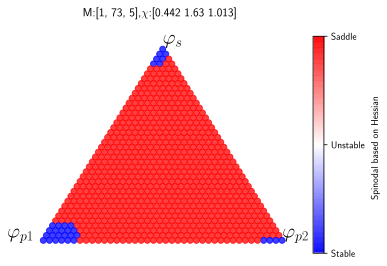

In [26]:
# get spinodal with hessian computation
from solvers import spinodal
from solvers.utils import plotlocus
s = spinodal.Spinodal(grid,gmix,energy=energy)
curvature = s.get_spinodal()
fig, ax = plt.subplots()
path = ax.scatter(coords[:,0], coords[:,1],c = curvature,cmap='bwr',alpha=0.75)
words = [r'$\varphi_{p1}$',r'$\varphi_{p2}$',r'$\varphi_{s}$']
xs = [-0.15,1,0.5]
ys = [0,0,np.sqrt(3)/2+0.01]
for x, y, s in zip(xs,ys,words):
    plt.text(x,y,s,fontsize=20)
    
cbar = fig.colorbar(path, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Stable', 'Unstable', 'Saddle'])
cbar.set_label('Spinodal based on Hessian')
ax.set_title(info['params'],pad=20)
plt.axis('off')
#plt.savefig('../figures/May13Wed/'+info['fname']+'.png',dpi=500,bbox_inches='tight')
plt.show()

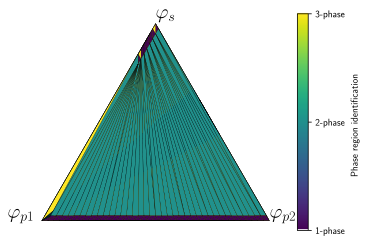

In [27]:
from solvers.cem import CEMLaplace

cem = CEMLaplace(grid,gmix,energy=energy)
fig, ax = plt.subplots()
ax = cem.plot_binodal(ax,fig)
plt.axis('off')
plt.show()


In [28]:
# import plotly.figure_factory as ff

# import numpy as np
# from scipy.spatial import Delaunay

# def plot_energy_landscape(x,y,z):
#     tri = Delaunay(np.asarray([x,y]).T)
#     simplices = tri.simplices

#     fig = ff.create_trisurf(x=x, y=y, z=z,
#                              simplices=simplices,
#                              title="Energy landscape")
#     fig.show()
# plot_energy_landscape(coords[:,0], coords[:,1],energy)

In [29]:
# def plot_convex_envelope(x,y,z,simplices):
#     fig = ff.create_trisurf(x=x, y=y, z=z,
#                              simplices=simplices,
#                              title="Energy landscape")
#     fig.show()
# plot_convex_envelope(coords[:,0], coords[:,1],energy,simplices)    

In [30]:
simplices = []
for simplex in hull.simplices:
    point_class = np.sum(np.isclose(grid[simplex],0.001),axis=1)
    #print(grid[simplex],3-point_class)
    point_class = np.unique(3 - point_class)
#     if len(point_class)==1:
#         if point_class==2:
#             pass
#         if point_class == 1:
#             pass
#         else:
#             simplices.append(simplex)
    if (point_class==1).any():
        pass
    else:
        simplices.append(simplex)

# from IPython import display
# import time

# for simplex in simplices:
#     fig, ax = plt.subplots()
#     ax.set_aspect('equal')
#     tpc = ax.triplot(coords[:,0], coords[:,1], simplices)
#     ax.add_patch(plt.Polygon(coords[simplex], color='red'))
#     plt.show()    
#     display.clear_output(wait=True)
#     time.sleep(0.001)
#     plt.close()

2020-05-23 15:27:29,014	ERROR worker.py:700 -- Calling ray.init() again after it has already been called.


[1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1]


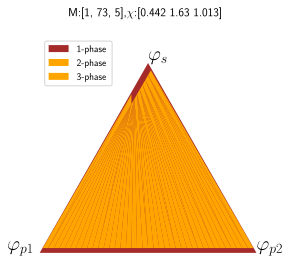

In [54]:
import ray
ray.init(ignore_reinit_error=True)

@ray.remote    
def label_triangle(triangle):
    tri_coords = coords[triangle,:]
    dist = squareform(pdist(tri_coords,'euclidean'))
    adjacency = dist<thresh
    adjacency =  adjacency.astype(int)  
    graph = csr_matrix(adjacency)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    
    return n_components

@ray.remote
def get_phase_diagram(simplices):
    num_comps = [label_triangle.remote(triangle) for triangle in simplices]
    num_comps = ray.get(num_comps)
    
    return num_comps
    
num_comps = get_phase_diagram.remote(simplices)
num_comps = ray.get(num_comps)
print(num_comps)    
    
fig, ax = plt.subplots()
ax.set_aspect('equal')
poly_coords = np.array([[0.0,0.0],[1.0,0.0],[0.5,np.sqrt(3)/2+0.01]])
ax.add_patch(plt.Polygon(poly_coords,edgecolor=None, facecolor='brown',fill=True))
words = [r'$\varphi_{p1}$',r'$\varphi_{p2}$',r'$\varphi_{s}$']
xs = [-0.15,1,0.5]
ys = [0,0,np.sqrt(3)/2+0.01]
for x, y, s in zip(xs,ys,words):
    plt.text(x,y,s,fontsize=20)
for i, triangle in zip(num_comps,simplices):
    tri_coords = coords[triangle,:]
    if i==2:
        ax.add_patch(plt.Polygon(tri_coords, edgecolor=None,facecolor='orange',fill=True))
    elif i==3:
        ax.add_patch(plt.Polygon(tri_coords,edgecolor=None, facecolor='lightblue',fill=True))

ax.set_title(info['params'],pad=20)
plt.axis('off')
plt.legend(['1-phase','2-phase','3-phase'])
#plt.savefig('../figures/May13Wed/'+info['fname']+'.png',dpi=500,bbox_inches='tight')
plt.show()